# 05 - Late Fusion Multimodal Deepfake Detection

## Objective
Combine predictions from individual modality classifiers (late fusion).

## Approach
1. Train separate classifiers for each modality
2. Combine predictions using weighted voting or learned fusion
3. Compare with early fusion

## Fusion Strategies
- Average voting
- Weighted voting (learned weights)
- Meta-classifier on predictions

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import torchvision.transforms as transforms

# Audio processing
import librosa

# Model imports
import timm
from transformers import Wav2Vec2Model
import torchvision.models.video as video_models

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

C:\Users\akshay-stu\miniconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
class ConvNeXtDeepfakeDetector(nn.Module):
    """Image classifier with full classification head"""
    def __init__(self, model_name='convnext_base', freeze_backbone=True):
        super().__init__()
        self.convnext = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        if freeze_backbone:
            for param in self.convnext.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.convnext.num_features
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        features = self.convnext(x)
        return self.classifier(features)

class Wav2Vec2Detector(nn.Module):
    """Audio classifier with full classification head"""
    def __init__(self, model_name='facebook/wav2vec2-base', freeze_backbone=True):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.wav2vec2.config.hidden_size
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        outputs = self.wav2vec2(x)
        hidden_states = outputs.last_hidden_state
        pooled = self.pool(hidden_states.transpose(1, 2)).squeeze(-1)
        return self.classifier(pooled)

class ResNet3DDetector(nn.Module):
    """Video classifier with full classification head"""
    def __init__(self, pretrained=True):
        super().__init__()
        self.resnet3d = video_models.r3d_18(weights='DEFAULT' if pretrained else None)
        self.feature_extractor = nn.Sequential(*list(self.resnet3d.children())[:-1])
        self.feature_dim = 512
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        features = self.feature_extractor(x)
        features = features.squeeze(-1).squeeze(-1).squeeze(-1)
        return self.classifier(features)

print('Individual model classes defined!')

Individual model classes defined!


In [4]:
# Dataset paths
TRAIN_FAKE_DIR_IMG = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/fake'
TRAIN_REAL_DIR_IMG = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/real'
TEST_FAKE_DIR_IMG = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/fake'
TEST_REAL_DIR_IMG = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/real'

REAL_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/REAL'
FAKE_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/FAKE'

TRAIN_FAKE_DIR_VID = '../dfd_faces/train/fake'
TRAIN_REAL_DIR_VID = '../dfd_faces/train/real'
TEST_FAKE_DIR_VID = '../dfd_faces/test/fake'
TEST_REAL_DIR_VID = '../dfd_faces/test/real'

# Parameters
IMG_SIZE = 224
NUM_FRAMES = 16
SAMPLE_RATE = 16000
MAX_AUDIO_LENGTH = SAMPLE_RATE * 10

BATCH_SIZE = 4
EPOCHS = 15
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

print("Configuration set!")

Configuration set!


In [5]:
class LateFusionDetector(nn.Module):
    """Late Fusion: Combines predictions from individual classifiers"""
    def __init__(self, image_model, audio_model, video_model, fusion_type='weighted'):
        super().__init__()
        self.image_model = image_model
        self.audio_model = audio_model
        self.video_model = video_model
        self.fusion_type = fusion_type
        
        if fusion_type == 'weighted':
            # Learnable weights for each modality
            self.weights = nn.Parameter(torch.ones(3) / 3)
        elif fusion_type == 'meta':
            # Meta-classifier learns to combine predictions
            self.meta_classifier = nn.Sequential(
                nn.Linear(6, 32),  # 3 models * 2 classes
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2)
            )
    
    def forward(self, image, audio, video):
        # Get predictions from each modality
        img_logits = self.image_model(image)
        aud_logits = self.audio_model(audio)
        vid_logits = self.video_model(video)
        
        # Convert to probabilities
        img_pred = torch.softmax(img_logits, dim=1)
        aud_pred = torch.softmax(aud_logits, dim=1)
        vid_pred = torch.softmax(vid_logits, dim=1)
        
        if self.fusion_type == 'average':
            # Simple average voting
            output = (img_pred + aud_pred + vid_pred) / 3
        elif self.fusion_type == 'weighted':
            # Weighted voting with learnable weights
            weights = torch.softmax(self.weights, dim=0)
            output = weights[0] * img_pred + weights[1] * aud_pred + weights[2] * vid_pred
        elif self.fusion_type == 'meta':
            # Meta-classifier on concatenated predictions
            combined = torch.cat([img_pred, aud_pred, vid_pred], dim=1)
            output = torch.softmax(self.meta_classifier(combined), dim=1)
        
        return output

print('Late Fusion Model Defined!')

Late Fusion Model Defined!


## Summary

### Late Fusion Strategies Tested:
1. **Average Fusion**: Simple average of predictions from all modalities
2. **Weighted Fusion**: Learnable weights for each modality (optimized during training)
3. **Meta-Classifier**: Neural network learns to combine predictions

### Key Insights:
- Late fusion allows each modality to make independent predictions
- Individual models are frozen (pretrained from baseline notebooks)
- Only fusion mechanism is trained
- Faster training than early fusion (fewer parameters to update)

### Comparison with Early Fusion:
- Early fusion: Combines features before classification
- Late fusion: Combines predictions after classification
- Trade-off: Early fusion learns joint representations, late fusion preserves modality-specific decisions

In [6]:
# Visualize best fusion strategy in detail
best_fusion = comparison_df.loc[comparison_df['accuracy'].idxmax(), 'fusion_type']
best_data = results[best_fusion]

print(f"\nDetailed Analysis: {best_fusion.upper()} Fusion (Best Performer)")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(best_data['train_losses'], label='Train', marker='o')
axes[0, 0].plot(best_data['val_losses'], label='Val', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title(f'{best_fusion.upper()} - Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(best_data['train_accs'], label='Train', marker='o')
axes[0, 1].plot(best_data['val_accs'], label='Val', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title(f'{best_fusion.upper()} - Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(best_data['final_labels'], best_data['final_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
axes[1, 0].set_title(f'{best_fusion.upper()} - Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# ROC Curve
if len(np.unique(best_data['final_labels'])) > 1:
    fpr, tpr, _ = roc_curve(best_data['final_labels'], best_data['final_probs'])
    roc_auc = roc_auc_score(best_data['final_labels'], best_data['final_probs'])
    
    axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title(f'{best_fusion.upper()} - ROC Curve')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'late_fusion_{best_fusion}_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Detailed plot saved as 'late_fusion_{best_fusion}_detailed.png'")

NameError: name 'comparison_df' is not defined

NameError: name 'comparison_df' is not defined

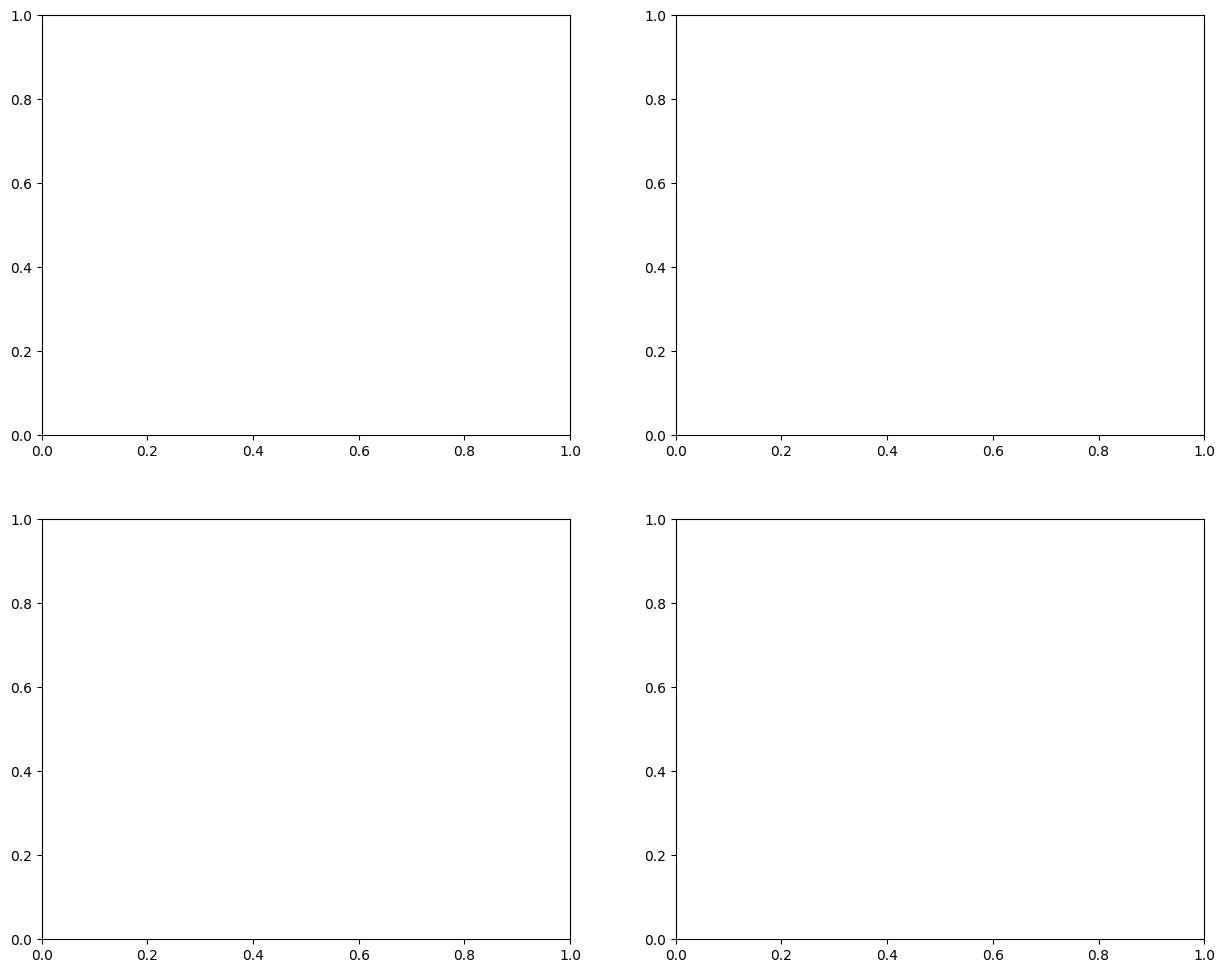

In [7]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
ax = axes[0, 0]
ax.bar(comparison_df['fusion_type'], comparison_df['accuracy'])
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
ax.grid(alpha=0.3)

# F1 Score comparison
ax = axes[0, 1]
ax.bar(comparison_df['fusion_type'], comparison_df['f1'])
ax.set_title('F1-Score Comparison')
ax.set_ylabel('F1-Score')
ax.set_ylim([0, 1])
ax.grid(alpha=0.3)

# ROC-AUC comparison
ax = axes[1, 0]
ax.bar(comparison_df['fusion_type'], comparison_df['roc_auc'])
ax.set_title('ROC-AUC Comparison')
ax.set_ylabel('ROC-AUC')
ax.set_ylim([0, 1])
ax.grid(alpha=0.3)

# Training time comparison
ax = axes[1, 1]
ax.bar(comparison_df['fusion_type'], comparison_df['training_time'])
ax.set_title('Training Time Comparison')
ax.set_ylabel('Time (seconds)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('late_fusion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved as 'late_fusion_comparison.png'")

In [8]:
# Compare all fusion strategies
comparison_data = []
for fusion_type, data in results.items():
    metrics = data['metrics']
    comparison_data.append({
        'fusion_type': fusion_type,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1'],
        'roc_auc': metrics['roc_auc'],
        'training_time': metrics['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nLate Fusion Strategy Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('late_fusion_results.csv', index=False)
print("\n✓ Results saved as 'late_fusion_results.csv'")

NameError: name 'results' is not defined

In [9]:
# Train all three fusion strategies
fusion_types = ['average', 'weighted', 'meta']
results = {}

for fusion_type in fusion_types:
    print(f"\n{'='*60}")
    print(f"Training Late Fusion: {fusion_type.upper()}")
    print(f"{'='*60}\n")
    
    # Create model
    model = LateFusionDetector(image_model, audio_model, video_model, fusion_type=fusion_type)
    model = model.to(device)
    
    # Show trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    best_state = None
    
    import time
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 60)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Evaluate
        val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = model.state_dict().copy()
            print(f"✓ New best accuracy: {best_acc:.2f}%")
        
        scheduler.step()
    
    training_time = time.time() - start_time
    
    # Load best model
    model.load_state_dict(best_state)
    
    # Final evaluation
    print(f"\nFinal evaluation on best model...")
    _, final_preds, final_labels, final_probs = evaluate(model, test_loader, criterion, device)
    
    metrics = calculate_metrics(final_labels, final_preds, final_probs)
    metrics['training_time'] = training_time
    metrics['best_val_acc'] = best_acc
    metrics['fusion_type'] = fusion_type
    
    # Store results
    results[fusion_type] = {
        'model': model,
        'metrics': metrics,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_preds': final_preds,
        'final_labels': final_labels,
        'final_probs': final_probs
    }
    
    print(f"\n{fusion_type.upper()} Fusion Results:")
    print("-" * 60)
    for key, value in metrics.items():
        if key == 'training_time':
            print(f"{key}: {value:.2f}s ({value/60:.2f} min)")
        elif key != 'fusion_type':
            print(f"{key}: {value:.4f}")
    
    # Save model
    torch.save(model.state_dict(), f'late_fusion_{fusion_type}_model.pth')
    print(f"✓ Model saved as 'late_fusion_{fusion_type}_model.pth'")

print(f"\n{'='*60}")
print("ALL LATE FUSION TRAINING COMPLETE!")
print(f"{'='*60}")


Training Late Fusion: AVERAGE



NameError: name 'image_model' is not defined

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    pbar = tqdm(loader, desc='Training')
    for image, audio, video, labels in pbar:
        image = image.to(device)
        audio = audio.to(device)
        video = video.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(image, audio, video)
        
        # For late fusion, output is already probabilities
        # Convert back to logits for CrossEntropyLoss
        outputs = torch.log(outputs + 1e-8)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{running_loss/len(pbar):.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Evaluating')
        for image, audio, video, labels in pbar:
            image = image.to(device)
            audio = audio.to(device)
            video = video.to(device)
            labels = labels.to(device)
            
            outputs = model(image, audio, video)
            outputs_log = torch.log(outputs + 1e-8)
            loss = criterion(outputs_log, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs[:, 1].cpu().numpy())
    
    return running_loss / len(loader), all_preds, all_labels, all_probs

def calculate_metrics(y_true, y_pred, y_probs):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_probs) if len(np.unique(y_true)) > 1 else 0.0
    }

print('Training functions defined!')

In [ ]:
print("Loading pretrained models...")
print("=" * 60)

# Load image model
image_model = ConvNeXtDeepfakeDetector(freeze_backbone=True)
if os.path.exists('best_image_model_convnext.pth'):
    print("✓ Loading saved ConvNeXt weights")
    try:
        state_dict = torch.load('best_image_model_convnext.pth', map_location=device)
        image_model.load_state_dict(state_dict, strict=False)
        print("  ConvNeXt loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained")
else:
    print("✗ No saved ConvNeXt found, using pretrained from timm")

# Load audio model
audio_model = Wav2Vec2Detector(freeze_backbone=True)
if os.path.exists('best_audio_model_wav2vec2.pth'):
    print("✓ Loading saved Wav2Vec2 weights")
    try:
        state_dict = torch.load('best_audio_model_wav2vec2.pth', map_location=device)
        audio_model.load_state_dict(state_dict, strict=False)
        print("  Wav2Vec2 loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained")
else:
    print("✗ No saved Wav2Vec2 found, using pretrained from HuggingFace")

# Load video model
video_model = ResNet3DDetector(pretrained=True)
if os.path.exists('best_video_model_resnet3d.pth'):
    print("✓ Loading saved 3D ResNet weights")
    try:
        state_dict = torch.load('best_video_model_resnet3d.pth', map_location=device)
        video_model.load_state_dict(state_dict, strict=False)
        print("  3D ResNet loaded successfully!")
    except Exception as e:
        print(f"  Warning: Could not load weights ({e}), using pretrained")
else:
    print("✗ No saved 3D ResNet found, using pretrained from torchvision")

print("=" * 60)

# Freeze all individual model parameters
for param in image_model.parameters():
    param.requires_grad = False
for param in audio_model.parameters():
    param.requires_grad = False
for param in video_model.parameters():
    param.requires_grad = False

print("\nIndividual models loaded and frozen!")
print("Ready for late fusion training...")

In [ ]:
train_dataset = MultimodalDeepfakeDataset(mode='train')
test_dataset = MultimodalDeepfakeDataset(mode='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

In [ ]:
class MultimodalDeepfakeDataset(Dataset):
    """Dataset that returns image, audio, and video for the same sample"""
    def __init__(self, mode='train'):
        self.mode = mode
        
        if mode == 'train':
            self.img_fake_dir = TRAIN_FAKE_DIR_IMG
            self.img_real_dir = TRAIN_REAL_DIR_IMG
            self.vid_fake_dir = TRAIN_FAKE_DIR_VID
            self.vid_real_dir = TRAIN_REAL_DIR_VID
        else:
            self.img_fake_dir = TEST_FAKE_DIR_IMG
            self.img_real_dir = TEST_REAL_DIR_IMG
            self.vid_fake_dir = TEST_FAKE_DIR_VID
            self.vid_real_dir = TEST_REAL_DIR_VID
        
        # Load image paths
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(self.img_fake_dir):
            fake_imgs = [os.path.join(self.img_fake_dir, f) for f in os.listdir(self.img_fake_dir) 
                        if f.endswith(('.jpg', '.png'))]
            self.image_paths.extend(fake_imgs[:100])
            self.labels.extend([1] * len(fake_imgs[:100]))
        
        if os.path.exists(self.img_real_dir):
            real_imgs = [os.path.join(self.img_real_dir, f) for f in os.listdir(self.img_real_dir) 
                        if f.endswith(('.jpg', '.png'))]
            self.image_paths.extend(real_imgs[:100])
            self.labels.extend([0] * len(real_imgs[:100]))
        
        # Load audio paths
        self.audio_paths = []
        if os.path.exists(FAKE_AUDIO_DIR):
            fake_aud = [os.path.join(FAKE_AUDIO_DIR, f) for f in os.listdir(FAKE_AUDIO_DIR) 
                       if f.endswith(('.wav', '.mp3'))][:50]
            self.audio_paths.extend(fake_aud)
        
        if os.path.exists(REAL_AUDIO_DIR):
            real_aud = [os.path.join(REAL_AUDIO_DIR, f) for f in os.listdir(REAL_AUDIO_DIR) 
                       if f.endswith(('.wav', '.mp3'))][:50]
            self.audio_paths.extend(real_aud)
        
        # Load video folders
        self.video_folders = []
        if os.path.exists(self.vid_fake_dir):
            fake_vids = [os.path.join(self.vid_fake_dir, f) for f in os.listdir(self.vid_fake_dir) 
                        if os.path.isdir(os.path.join(self.vid_fake_dir, f))][:50]
            self.video_folders.extend(fake_vids)
        
        if os.path.exists(self.vid_real_dir):
            real_vids = [os.path.join(self.vid_real_dir, f) for f in os.listdir(self.vid_real_dir) 
                        if os.path.isdir(os.path.join(self.vid_real_dir, f))][:50]
            self.video_folders.extend(real_vids)
        
        # Image transforms
        self.img_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        print(f"{mode.upper()}: {len(self.image_paths)} samples")
    
    def __len__(self):
        return min(len(self.image_paths), len(self.audio_paths), len(self.video_folders))
    
    def load_image(self, idx):
        img_path = self.image_paths[idx % len(self.image_paths)]
        try:
            img = Image.open(img_path).convert('RGB')
            return self.img_transform(img)
        except:
            return torch.zeros(3, IMG_SIZE, IMG_SIZE)
    
    def load_audio(self, idx):
        aud_path = self.audio_paths[idx % len(self.audio_paths)]
        try:
            audio, _ = librosa.load(aud_path, sr=SAMPLE_RATE, duration=10)
            if len(audio) < MAX_AUDIO_LENGTH:
                audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
            else:
                audio = audio[:MAX_AUDIO_LENGTH]
            return torch.FloatTensor(audio)
        except:
            return torch.zeros(MAX_AUDIO_LENGTH)
    
    def load_video(self, idx):
        vid_folder = self.video_folders[idx % len(self.video_folders)]
        try:
            frames_files = sorted([f for f in os.listdir(vid_folder) if f.endswith(('.jpg', '.png'))])
            indices = np.linspace(0, len(frames_files)-1, NUM_FRAMES, dtype=int)
            
            frames = []
            for i in indices:
                img = Image.open(os.path.join(vid_folder, frames_files[i])).convert('RGB')
                frames.append(self.img_transform(img))
            
            return torch.stack(frames)
        except:
            return torch.zeros(NUM_FRAMES, 3, IMG_SIZE, IMG_SIZE)
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        audio = self.load_audio(idx)
        video = self.load_video(idx)
        label = self.labels[idx % len(self.labels)]
        
        return image, audio, video, label

print('Multimodal Dataset defined!')